In [1]:
from torchvision.models import vgg19
from torch.autograd import Variable
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
image_size = 512 
is_cuda = torch.cuda.is_available()

preprocessing = transforms.Compose([transforms.Resize(image_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), 
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
processing = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), 
                           ])
postprocess = transforms.Compose([transforms.ToPILImage()])

def postprocess_b(tensor): 
    t = processing(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postprocess(t)
    return img

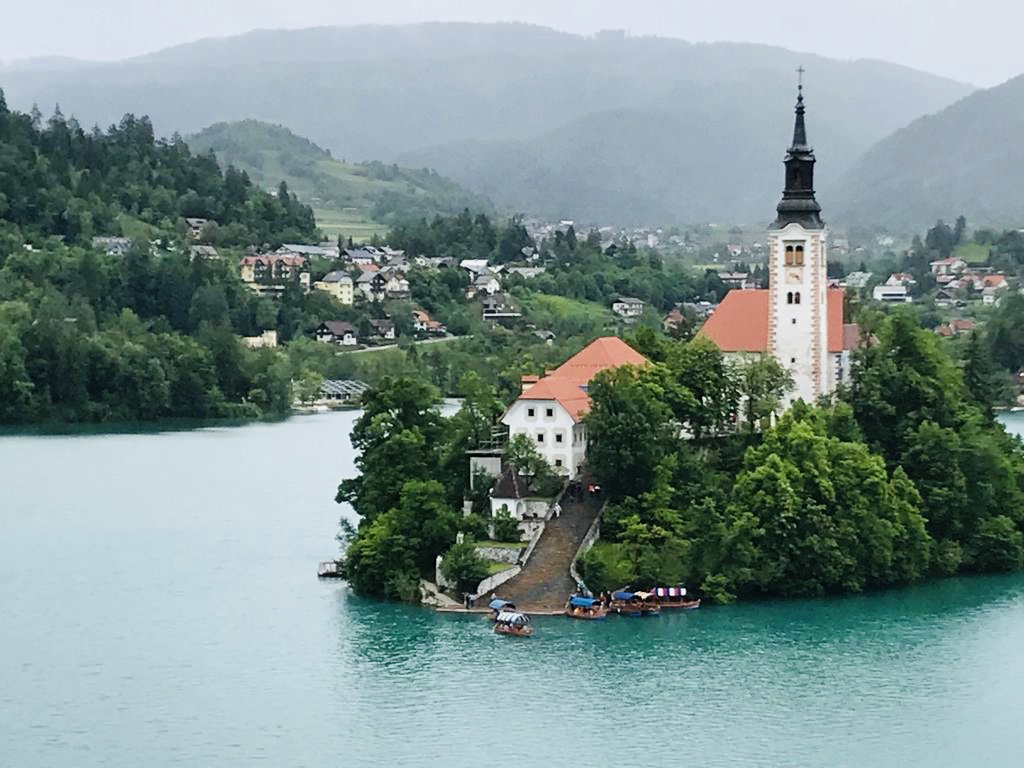

In [3]:
from IPython.display import Image 
Image('Images/style_image.jpg')
Image('Images/content_image.jpg')

In [4]:
def loader(image_name):
    image = Image.open(image_name)
    image = Variable(preprocessing(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

In [5]:
from PIL import Image
%pylab inline
style_image = loader("Images/style_image.jpg")
content_image = loader("Images/content_image.jpg")

vgg = vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = False
if is_cuda:
    style_image = style_image.cuda()
    content_image = content_image.cuda()
    vgg = vgg.cuda()

output_image = Variable(content_image.data.clone(),requires_grad=True)

Populating the interactive namespace from numpy and matplotlib


In [6]:
style_layers = [1,6,11,20,25]
content_layers = [21]
loss_layers = style_layers + content_layers

In [7]:
class LayerActivations():
    features=[]
    
    def __init__(self,model,layer_nums):
        
        self.hooks = []
        for layer_num in layer_nums:
            self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))
    
    def hook_fn(self,module,input,output):
        self.features.append(output)

    
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [8]:
class GramMatrix(nn.Module):
    
    def forward(self,input):
        b,c,h,w = input.size()
        features = input.view(b,c,h*w)
        gram_matrix =  torch.bmm(features,features.transpose(1,2))
        gram_matrix.div_(h*w)
        return gram_matrix
        
class StyleLoss(nn.Module):
    
    def forward(self,inputs,targets):
        out = nn.MSELoss()(GramMatrix()(inputs),targets)
        return (out)

In [9]:
def extract_layers(layers,img,model=None):
    la = LayerActivations(model,layers)
    #Clearing the cache 
    la.features = []
    out = model(img)
    la.remove()
    return la.features

content_targets = extract_layers(content_layers,content_image,model=vgg)
content_targets = [t.detach() for t in content_targets]
style_targets = extract_layers(style_layers,style_image,model=vgg)
style_targets = [GramMatrix()(t).detach() for t in style_targets]
targets = style_targets + content_targets

In [10]:
loss_fns = [StyleLoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if is_cuda:
    loss_fns = [fn.cuda() for fn in loss_fns]

In [11]:
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

In [12]:
#run style transfer
maximum_iterations = 500
show_iteration = 50
optimizer = optim.LBFGS([output_image]);
n_iteration=[0]

while n_iteration[0] <= maximum_iterations:

    def closure():
        optimizer.zero_grad()
        
        out = extract_layers(loss_layers,output_image,model=vgg)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iteration[0]+=1
        if n_iteration[0]%show_iteration == (show_iteration-1):
            print('Iteration: %d, loss: %f'%(n_iteration[0]+1, loss.data[0]))

        return loss
    
    optimizer.step(closure)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 50, loss: 55717.320312
Iteration: 100, loss: 27448.371094
Iteration: 150, loss: 21544.564453
Iteration: 200, loss: 19304.714844
Iteration: 250, loss: 18099.943359
Iteration: 300, loss: 17359.181641
Iteration: 350, loss: 16887.625000
Iteration: 400, loss: 16547.591797
Iteration: 450, loss: 16305.552734
Iteration: 500, loss: 16122.099609


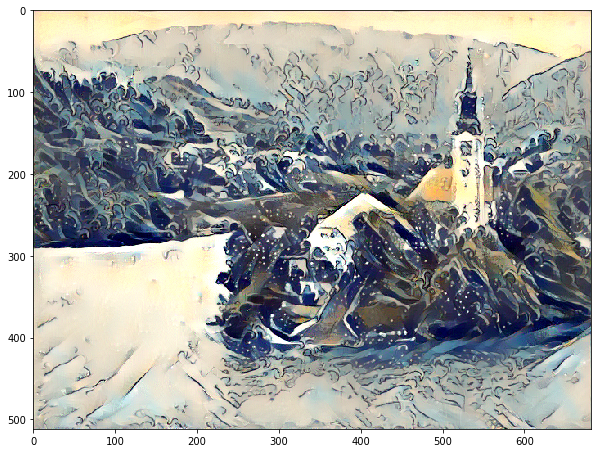

In [16]:
out_img_hr = postprocess_b(output_image.data[0].cpu().squeeze())

imshow(out_img_hr)
gcf().set_size_inches(10,10)